# Wine Quality Prediction Analysis
##### Author: Elif Ece Can
##### Date: 14.01.2025

In [5]:
#### Description

## Load and Format the Dataset

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import sklearn
sns.set_style("whitegrid")

In [9]:
df = pd.read_csv('data//red_wine_quality.txt', delimiter=';', skiprows=1)
column_names = [
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
    "pH", "sulphates", "alcohol", "quality"
]

df.columns = column_names
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
2,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
3,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


## Data Preprocessing Steps

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [12]:
X = df.drop("quality", axis=1)
y = df["quality"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)  # Ensure consistent scaling

## Multiple Regression

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [19]:
model = LinearRegression()
model.fit(X_train_std, y_train)

# Print coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [ 0.05464986 -0.18803671 -0.03762412  0.02916585 -0.09421664  0.0363169
 -0.10343009 -0.04760912 -0.04832424  0.16568474  0.29149372]
Intercept: 5.638497652582161


In [21]:
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std) 

In [23]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nTraining R² score: ", r2_train)
print("\nTest R² score: ", r2_test)


Training R² score:  0.3667734106020656

Test R² score:  0.32952875685233163


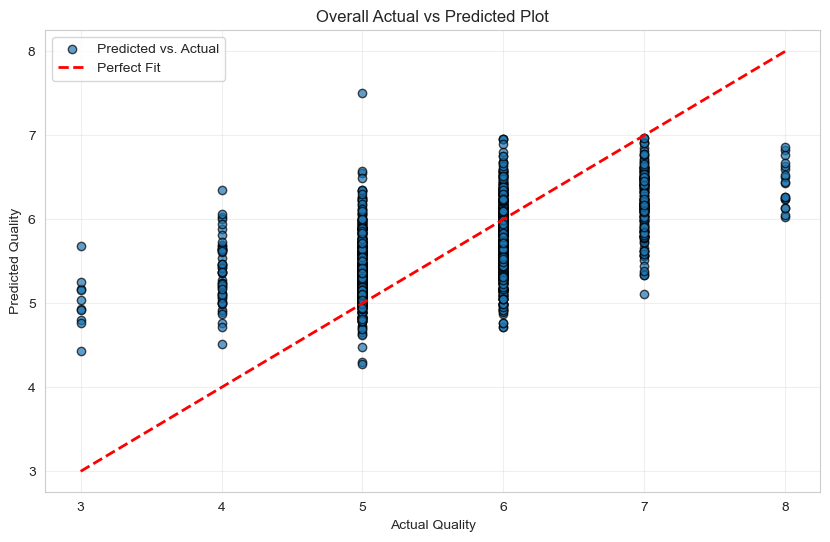

In [25]:
actual_values = pd.concat([y_train, y_test])
predicted_values = pd.concat([pd.Series(y_train_pred, index=y_train.index), pd.Series(y_test_pred, index=y_test.index)])

plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.7, edgecolor='k', label='Predicted vs. Actual')
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'r--', lw=2, label='Perfect Fit')
plt.title('Overall Actual vs Predicted Plot')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Since the R² was low and I had many features, I wanted to check for multi-collinearity:

                 Feature          VIF
0          fixed acidity    74.456135
1       volatile acidity    17.043284
2            citric acid     9.187078
3         residual sugar     4.661792
4              chlorides     6.552575
5    free sulfur dioxide     6.442177
6   total sulfur dioxide     6.518329
7                density  1479.125512
8                     pH  1071.330826
9              sulphates    21.581456
10               alcohol   124.408742


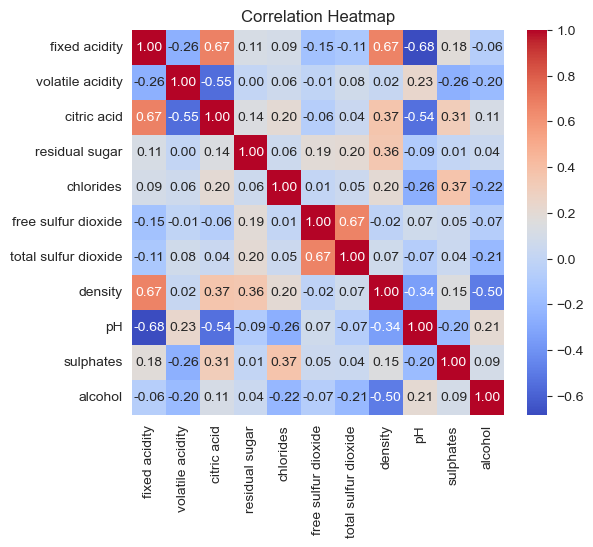

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

corr_matrix = df.drop("quality", axis=1).corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### I have tried Ridge, Lasso, and PCA to see if they solve the issue:

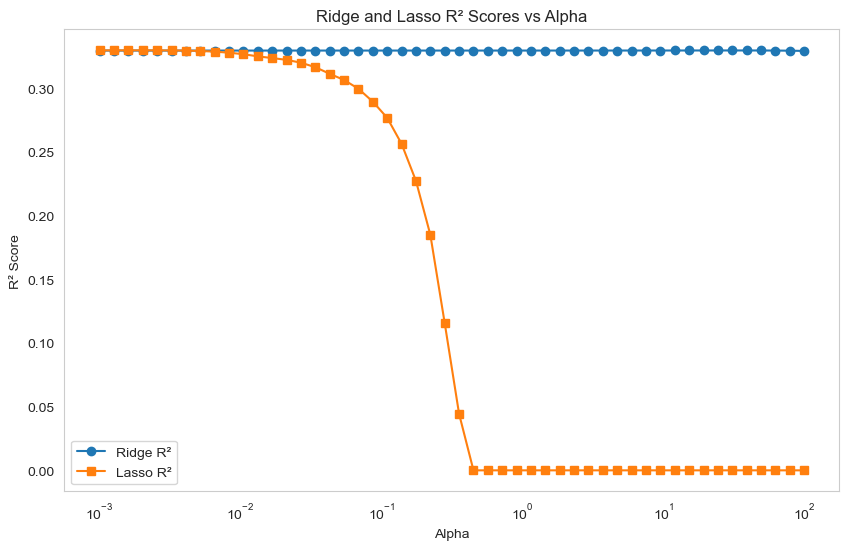

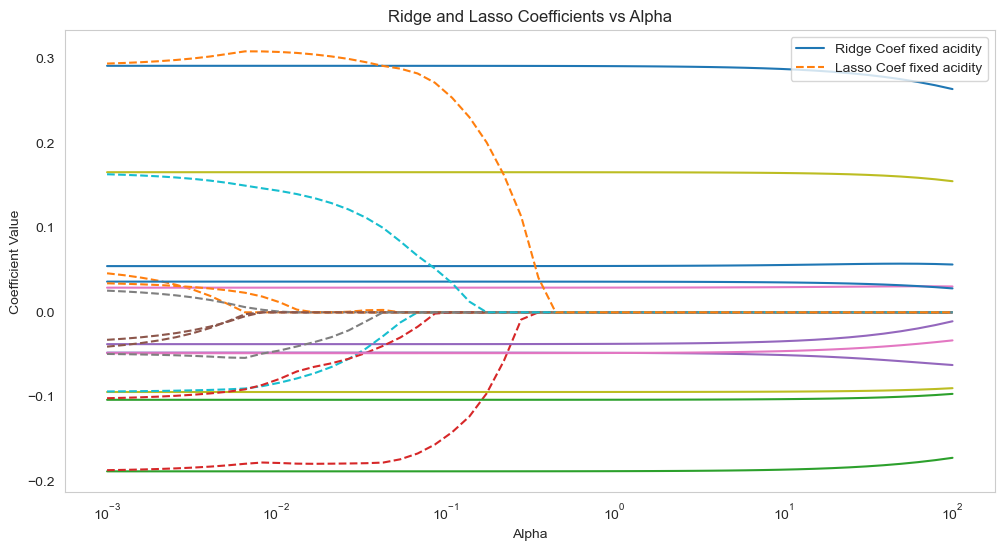

In [30]:
from sklearn.linear_model import Ridge, Lasso

# Define alpha range
alphas = np.logspace(-3, 2, 50)  # Alpha values from 0.001 to 100
ridge_scores = []
lasso_scores = []
ridge_coefficients = []
lasso_coefficients = []

# Loop through alpha values
for alpha in alphas:
    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_std, y_train)
    ridge_scores.append(ridge.score(X_test_std, y_test))  # Use scaled test data
    ridge_coefficients.append(ridge.coef_)
    
    # Lasso Regression
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_std, y_train)
    lasso_scores.append(lasso.score(X_test_std, y_test))  # Use scaled test data
    lasso_coefficients.append(lasso.coef_)

# Plotting R² scores for Ridge and Lasso
plt.figure(figsize=(10, 6))
plt.plot(alphas, ridge_scores, label="Ridge R²", marker='o')
plt.plot(alphas, lasso_scores, label="Lasso R²", marker='s')
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Ridge and Lasso R² Scores vs Alpha")
plt.legend()
plt.grid()
plt.show()

# Plotting coefficients as alpha increases
ridge_coefficients = np.array(ridge_coefficients)
lasso_coefficients = np.array(lasso_coefficients)

plt.figure(figsize=(12, 6))
for i in range(X_train.shape[1]):
    plt.plot(alphas, ridge_coefficients[:, i], label=f"Ridge Coef {X.columns[i]}" if i == 0 else "")
    plt.plot(alphas, lasso_coefficients[:, i], linestyle='dashed', label=f"Lasso Coef {X.columns[i]}" if i == 0 else "")

plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Coefficient Value")
plt.title("Ridge and Lasso Coefficients vs Alpha")
plt.legend()
plt.grid()
plt.show()

In [32]:
### try pca

In [33]:
### None of them increased the R² score since: 

## Lastly, have tried Random Forest model:

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd

X = df.drop(columns=["quality"])
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)


In [47]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nTraining R² score: ", r2_train)
print("\nTest R² score: ", r2_test)


Training R² score:  0.9274064976943126

Test R² score:  0.4845730278777969


In [49]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\nTraining Mean Squared Error: ", mse_train)
print("\nTest Mean Squared Error: ", mse_test)


Training Mean Squared Error:  0.04788364632237871

Test Mean Squared Error:  0.32012343750000005


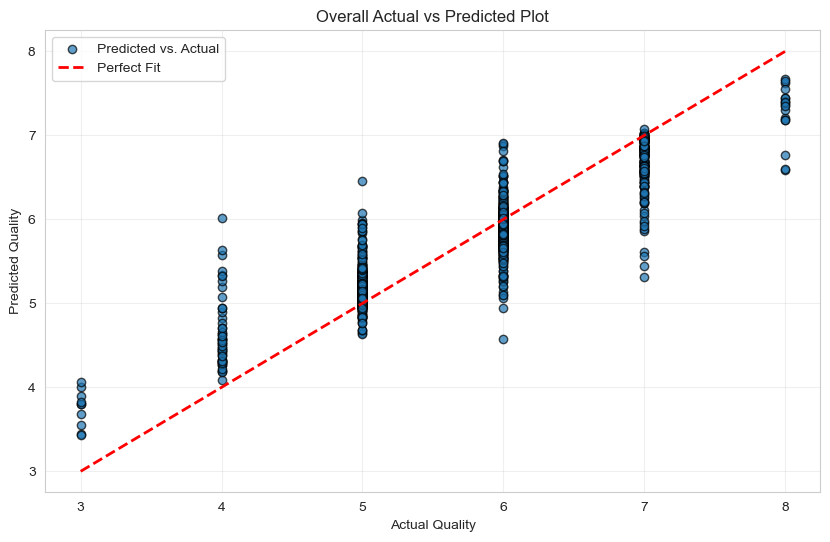

In [51]:
actual_values = pd.concat([y_train, y_test])
predicted_values = pd.concat([pd.Series(y_train_pred, index=y_train.index), pd.Series(y_test_pred, index=y_test.index)])

plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.7, edgecolor='k', label='Predicted vs. Actual')
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'r--', lw=2, label='Perfect Fit')
plt.title('Overall Actual vs Predicted Plot')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [53]:
### It worked because :